<a href="https://colab.research.google.com/github/rdonald03/cap-comp215/blob/main/Schelling's_Segregation_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Schelling's Segregation
**Ryan Donald**

**April 21st, 2023**

In 1969, Thomas Schelling proposed a cellular automaton model, that perhaps gives insight into racial, economic, sexist, etc, segregation.

Schelling's model is a grid of n cells, where each cell represents a house. Each house is then occupied with either a red or blue agent, which can each be interpreted as race, rich or poor, etc. There is also a 10% chance for a given house to be unoccupied, although the model in this notebook allows that percentage to be changed.

Initially, the red and blue agents are randomly placed into homes across the grid, but as the model runs the agents begin to move according to a rule.

If an agent has fewer than a certain number of neighbors the same as them, they will move to an unoccupied home. This number can be changed, and depending on it, provides interesting information on how segregation may occur.


#Citations

Used Animation2D and plot_2D_array from previous labs to help with animation and plotting

Original model this notebook was derived from: https://runestone.academy/ns/books/published/complex/AgentBasedModels/SchellingsModel.html

Other:
https://www.youtube.com/watch?v=42STyM7RfrU&list=LL&index=1

https://www.nytimes.com/interactive/2015/07/08/us/census-race-map.html

#Importation of necessary modules and configuring the notebook


In [ ]:
%matplotlib inline
import time
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as colors
import numpy as np
from scipy.signal import correlate2d
from scipy.stats import linregress
import random
import warnings
matplotlib.rc('animation', html='jshtml')
warnings.filterwarnings("ignore", category=RuntimeWarning)

#Code from previous labs to help with animation and plotting

In [ ]:

def plot_2D_array(array, axes=None, title='', **options):
    """ Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue. """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    axes.set_title(title)
    axes.set_xticks([], [])  # remove axes tick marks
    axes.set_yticks([], [])
    axes.imshow(array, **options)

class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number

      See https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/
          for a discussion of the pros and cons of various animation techniques in jupyter notebooks
    """

    def __init__(self, model, frames=50, steps_per_frame=1, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            for _ in range(self.steps_per_frame):
                self.model.step()
        self.model.draw(self.ax, step=step * self.steps_per_frame)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()  # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)  # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()  # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

#Creation of the Model


In [ ]:
class Schelling:

  WHITE = 0
  RED = 1
  BLUE = 2

  white = "#FFFFFF"
  red = "#FF0000"
  blue = "#0000FF"

  cmap = colors.ListedColormap([white, red, blue])

  kernel = np.array ([[1, 1, 1],
                      [1, 0, 1],
                      [1, 1, 1]])

  def __init__ (self, n, p, unoccupied):
    """Initializes the Schelling's Segregation Model
    n = Size of the grid
    p = Percentage of similar neighbors required for an agent to stay
    unoccupied = Percent of unoccupied homes (cells)"""
    self.n = n
    self.p = p
    self.unoccupied = unoccupied
    self.array = np.random.choice([0, 1, 2], (n, n), p=[unoccupied, (0.5-(unoccupied/2)), (0.5-(unoccupied/2))]) #Changed from textbook to have the ability to change unoccupied places

  def step (self):
    """Performs one time step of Schelling's Segregation, following all rules"""
    state = self.array
    red = state==1
    blue = state==2
    white = state==0

    num_red = correlate2d(red, self.kernel, mode = 'same')
    num_blue = correlate2d(blue, self.kernel, mode= 'same')
    num_neighbors = num_red + num_blue

    fraction_red = num_red / num_neighbors
    fraction_blue = num_blue / num_neighbors
    fraction_same = np.where (red, fraction_red, fraction_blue)
    fraction_same[white] = np.nan

    not_happy = fraction_same < self.p
    not_happy_loc = locs_where (not_happy)
    location_white = locs_where (white)

    num_empty = np.sum(white)
    for source in not_happy_loc:
        i = np.random.randint(num_empty)
        dest = location_white[i]

        state[dest] = state[source]
        state[source] = 0
        location_white[i] = source
    
  def draw (self, axes=None, step=''):
    '''Draws an instance of the segregation model'''
    axes or plt.axes
    title = f'Segregation, Timestep:{step}'
    plot_2D_array(self.array, axes=axes, title=title, cmap = self.cmap)


  def num_unhappy (self):
    """ Repeats a portion of the step function, and return the number of unhappy agents"""
    state = self.array
    red = state == 1
    blue = state == 2
    white = state == 0

    num_red = correlate2d(red, self.kernel, mode='same')
    num_blue = correlate2d(blue, self.kernel, mode='same')
    num_neighbors = num_red + num_blue

    fraction_red = num_red / num_neighbors
    fraction_blue = num_blue / num_neighbors
    fraction_same = np.where(red, fraction_red, fraction_blue)
    fraction_same[white] = np.nan

    unhappy = fraction_same < self.p
    num_unhappy = np.sum(unhappy)
    return num_unhappy

  def pct_unhappy (self):
    """Returns the percentage of unhappy agents in the grid"""
    return self.num_unhappy () / self.array.size

#Global function to determine coordinates

In [ ]:
def locs_where(condition):
  """Takes an array, and returns the coordinates as a list"""
  return list(zip(*np.nonzero(condition)))

#Animating The Model

Here you can change the values:


*   N = The size of the grid
*   P = The percentage required of similar neighbors for an agent to stay in a given place
*   Unoccupied = The percenrage of unoccupied homes


#Interesting Observation
When changing the value for p even slighty, the first thing we notice is the amount of segregation will vastly change. Looking at this through p increasing, we can see that the reason for this is because even if the p value is relatively small, once someone moves in one time step, in the next may now have caused another to move, therefore creating a series of events where a person moving will now cause others to move, resulting in very defined lines of segregation.

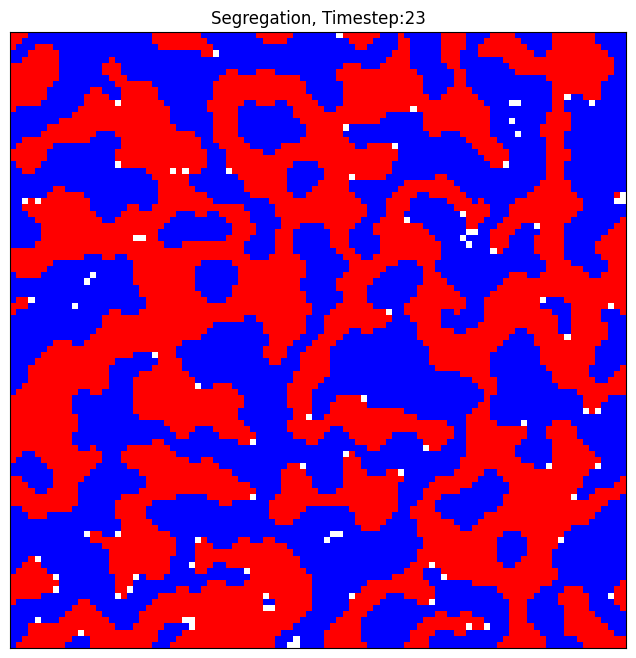

In [ ]:
n = 100
p = 0.4
unoccupied = 0.01



x = Schelling (n, p, unoccupied)   
b = Animation2D (x, 100)

b.animate (0.5)

#Testing Unhappiness

This test here perfoms three tests with multiple values for p, being 0.3, 0.5, 0.8. It's to be expected that lower values of p will have a lower unhappiness percentage to begin with, as well as reaching 0 quicker, but what is interesting here is to see that with higher values of p, comes the inability to reach 0, as well as staying at a extremely high percentage of unhappiness.

The reason for this goes back to the previous observation from the animation cell. If the p value for someone to move is so high, it becomes extremely difficult for someone to find a home that meets their expectations, therefore constantly moving, which in turn could perhaps make someone else move, therefore creating an infinite loop of moving between homes. 

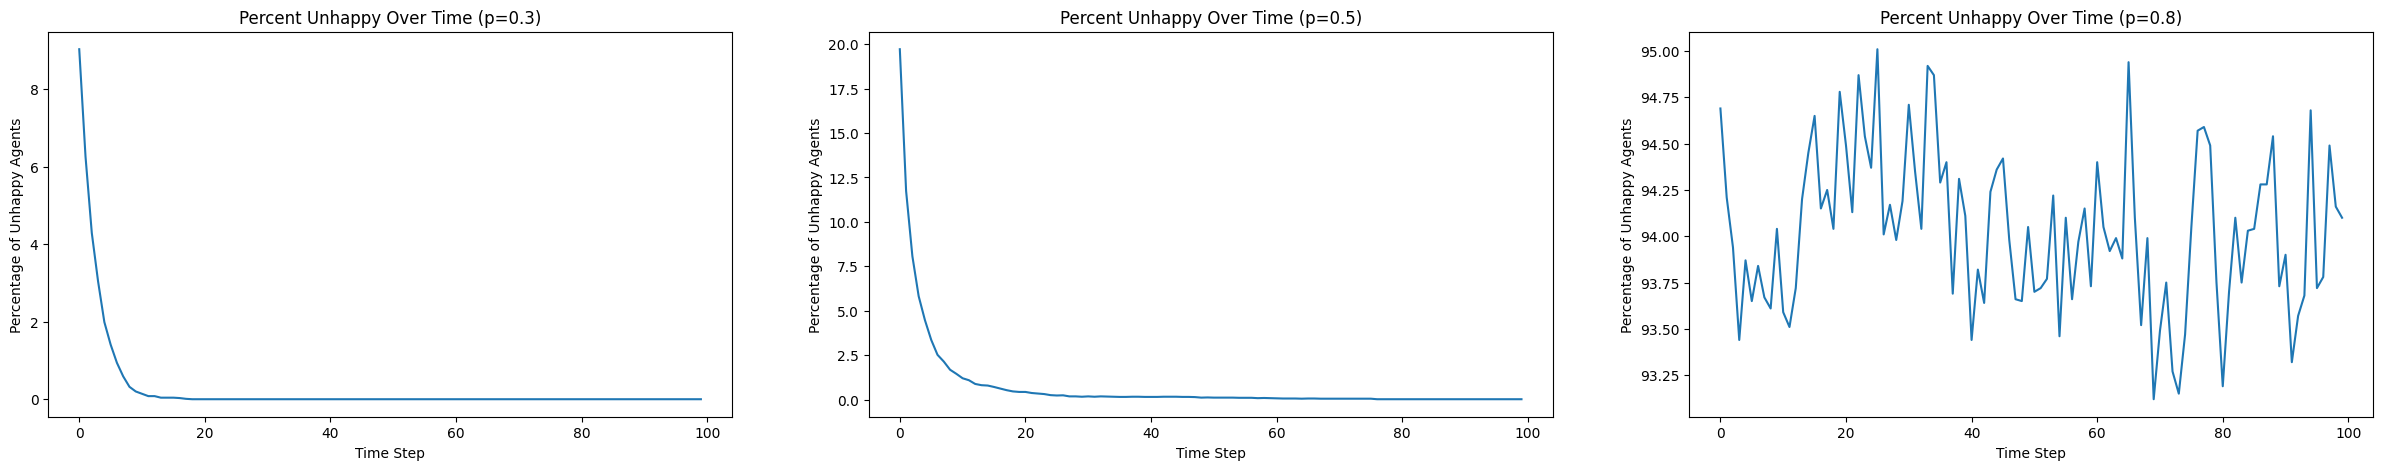

In [ ]:
p_values = [0.3, 0.5, 0.8]
unhappy_tests = [Schelling(n=100, p=p, unoccupied= 0.01) for p in p_values]

num_steps = 100 #Change this value to perform more time steps

plots = len(unhappy_tests)

fig, axes = plt.subplots(1, plots, figsize=(10*plots,5))

for i in range (3):
  steps = []
  pct_unhappy = []
  for j in range (num_steps):
      unhappy_tests[i].step()
      steps.append(j)
      pct_unhappy.append(unhappy_tests[i].pct_unhappy() * 100)
  axes[i].plot(steps, pct_unhappy)
  axes[i].set_xlabel ("Time Step")
  axes[i].set_ylabel ("Percentage of Unhappy Agents")
  axes[i].set_title (f"Percent Unhappy Over Time (p={p_values[i]})")

plt.show ()

#So what is this model really showing??? 
#<font color = 'red'>

(DO NOT OPEN THIS TEXTBLOCK, JPG IMAGE FILE WILL LAG OUT NOTEBOOK)
</font>

The primary reason for this models existence is to perhaps give reason to real life segregation as shown in the image below.

(Each color represents a different race)

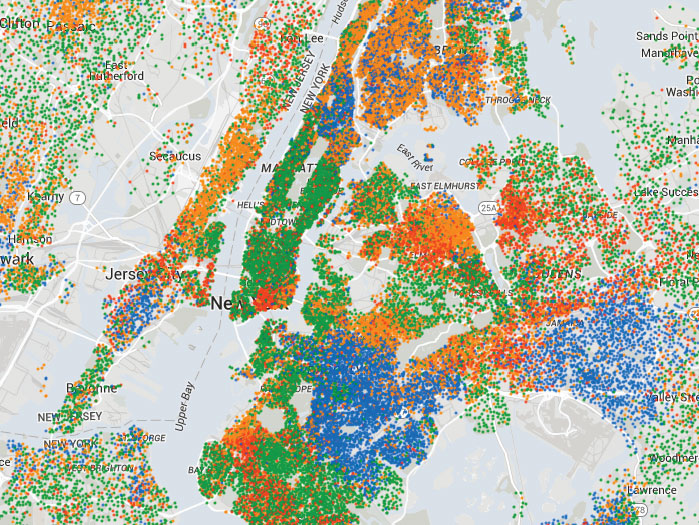

But what's interesting is that not only does it provide some potential reasoning, but also some information on why things may not be as they seem.

A common idea for why segregation occurs, for example when looking at the image above, many people assume that racism, sexism, econ-ism?, etc, is the obvious reason.

But what this model shows is that even with very very small values of similarity (p) segregation still ends up to atleast somewhat show itself, and in that, therefore shows in atleast the micro lens, that these discrimination ideas may not be entirely correct. Of course in some situations those ideas would be absolutely correct, but what this model shows is that it could be more of a more macro reasoning, instead of micro.

Continuing with why this model shows perhaps more macro reasonings instead of micro, we can look at the unhappiness test. We see with the lower values of p, that segregation does occur, just like how it does in the New York image, but when the p value reaches higher levels (being more discriminatory) we see that no one ever finds a permanent home, and when animated shows a random pattern just continuing to loop. This is interesting because this is not what we see in real life. In real life we do see this segregation, which does perhaps tell us that we as a society may not be so micro-ly discriminatory.

#Conclusion

Although this model provides many interesting insights into segregation, it does not provide absolutes, only potential reasonings. 

Nonetheless, looking at this through the lens of a programmer, shows an amazing model of complexity, and how simple rules end up providing extremely complex situations, from the segregation at lower p values, to the random continuing patterns at higher values.

Looking at this through the lens of a sociologist, even though this model is too simple to provide definitive reasonings, it still allows us to see potential reasons, and then provides us with initial ideas to then continue to question to perhaps find more reasonable conclusions.
